# Steps going to be followed

* Import the os, numpy, pandas, matplotlib, seaborn, tensorflow and sklearn libraries
* Load the data from the csv file
* Data path connection
* Data resizing
* Build CNN model

# Import the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Connect the paths and read the data

In [2]:
path = os.getcwd() + "\\train"
train = pd.read_csv(path + "\\train.csv")
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [3]:
train.shape

(6252, 2)

In [4]:
train_categories = {1 : 'Cargo',
2 : 'Military',
3 : 'Carrier',
4 : 'Cruise',
5 : 'Tankers'}

### Visualize the data balance

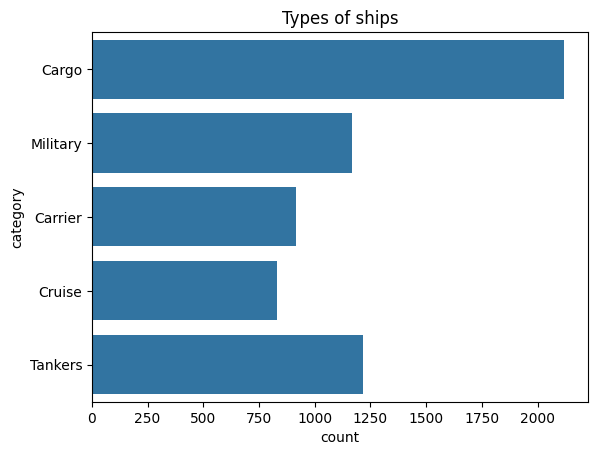

In [5]:
sns.countplot(data=train["category"].map(train_categories))
plt.title("Types of ships")
plt.show()

#### Data resizing

In [6]:
target_size = (128, 128)
resized_images = []
paths = []
for image in train["image"]:
    img_path = path + f"\\images\\{image}"
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img = tf.image.convert_image_dtype(img, tf.float16)
    img = tf.keras.utils.img_to_array(img)
    resized_images.append(img)
    paths.append(img_path)

In [7]:
resized_images = np.asarray(resized_images)

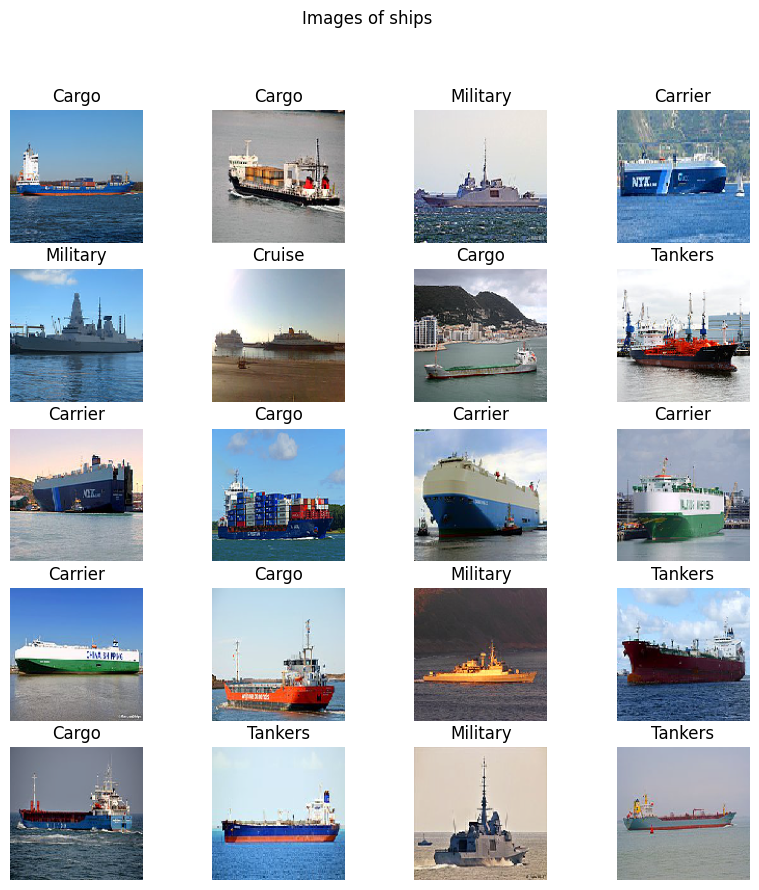

In [8]:
row = 5
col = 4
plt.figure(figsize=(10, 10))
plt.suptitle("Images of ships")
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(image)
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
plt.show()

#### Data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

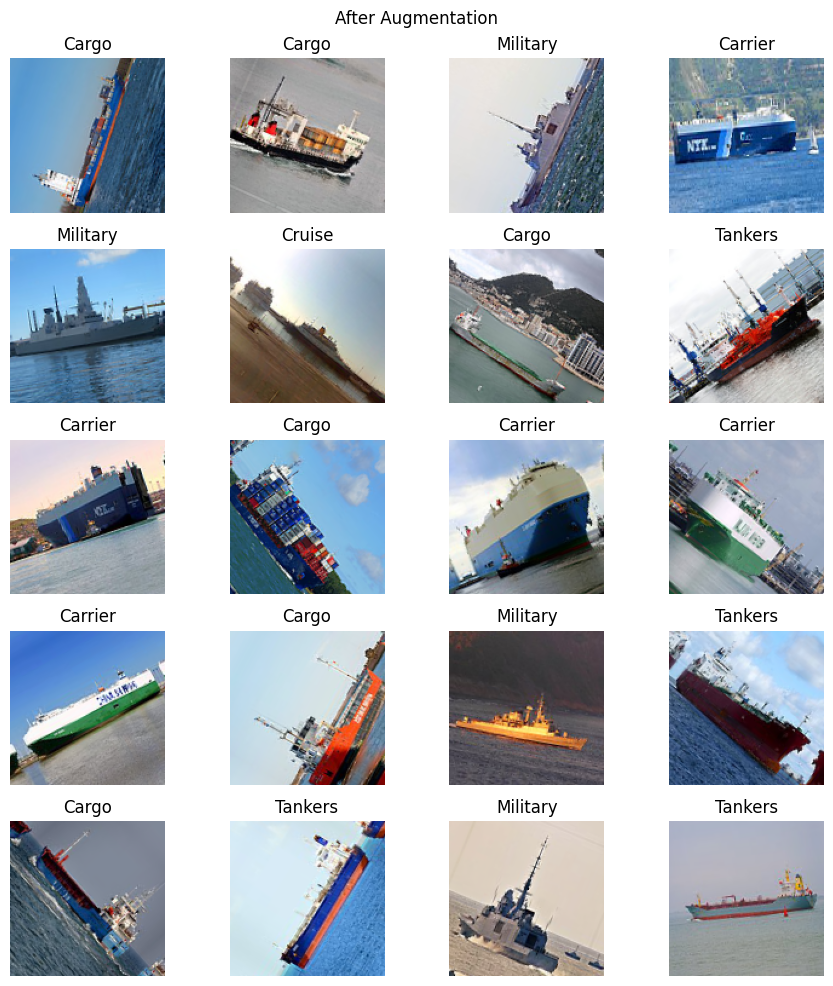

In [10]:
plt.figure(figsize=(10, 10))
plt.suptitle("After Augmentation")
augmented_image = data_augmentation(resized_images[:20])
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(augmented_image[i-1])
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout(pad=1)
plt.show()

In [11]:
values = train["category"] - 1
train_categories = {0 : 'Cargo',
1 : 'Military',
2 : 'Carrier',
3 : 'Cruise',
4 : 'Tankers'}

In [42]:
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    Conv2D(32, (2, 2), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (2, 2), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dense(5, activation="softmax")
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [44]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,881,957 (30.07 MB)

 Trainable params: 7,881,957 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((resized_images, values)).shuffle(1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [35]:
def divide(dataset):
    train_val = 0.8
    test_val = 0.1
    val_val = 0.1
    train_size = int(train_val * len(dataset))
    test_size = int(test_val * len(dataset))
    val_size = int(val_val * len(dataset))
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(train_size).skip(test_size).take(val_size)
    return train_dataset,  test_dataset, val_dataset

In [36]:
data_train, data_test, data_val = divide(dataset)

In [45]:
history = model.fit(data_train, epochs=10, validation_data=data_val)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.3646 - loss: 1.7116 - val_accuracy: 0.5609 - val_loss: 1.1318
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.5293 - loss: 1.1364 - val_accuracy: 0.5296 - val_loss: 1.1113
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.5826 - loss: 1.0251 - val_accuracy: 0.5905 - val_loss: 1.0334
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.6021 - loss: 0.9768 - val_accuracy: 0.6365 - val_loss: 0.9542
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.6238 - loss: 0.9288 - val_accuracy: 0.6184 - val_loss: 0.9364
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.6456 - loss: 0.8872 - val_accuracy: 0.6316 - val_loss: 0.8680
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.6473 - loss: 0.8627 - val_accuracy: 0.6595 - val_loss: 0.8636
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.6653 - loss: 0

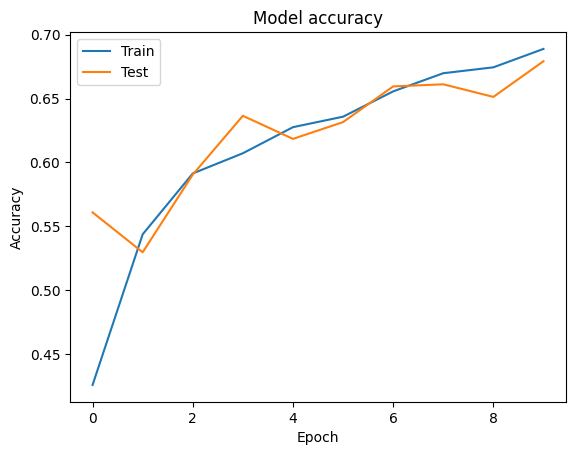

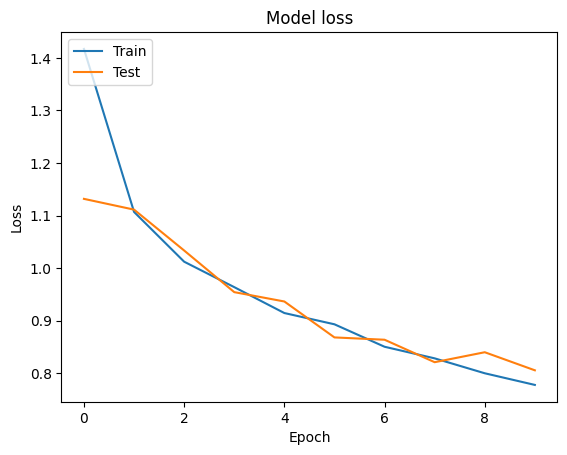

In [46]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()